# Film Data Analysis  -  Top Directors, Writers, Actors with respect to domesting ppratio

## Initial Setup

In [30]:
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from statsmodels.stats.multicomp import MultiComparison
import pandas as pd



In [31]:
# will be looking at a lot of tables, so make a report
def df_report(df):
    print(df.info())
    print('===========================================================\n')
    print(df.describe())
    print('===========================================================\n')
    print(df.head())

In [32]:
films = pd.read_csv('Data\\Reduced_Data\\films_2010.csv')

In [33]:
films.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63849 entries, 0 to 63848
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         63849 non-null  int64  
 1   primary_title      63849 non-null  object 
 2   year               63849 non-null  float64
 3   runtime_minutes    62741 non-null  float64
 4   genres             62322 non-null  object 
 5   movie_id           62741 non-null  object 
 6   writer             54128 non-null  object 
 7   director           62264 non-null  object 
 8   production_budget  2440 non-null   float64
 9   domestic_gross     4564 non-null   float64
 10  worldwide_gross    3372 non-null   float64
 11  studio             3381 non-null   object 
 12  foreign_gross      3398 non-null   float64
 13  averagerating      62783 non-null  float64
 14  numvotes           62779 non-null  float64
 15  log_numvotes       62115 non-null  float64
 16  actors             627

#### Get rid of what we don't need for the following analyses

In [34]:
drop_columns= ['Unnamed: 0', 'domestic_gross', 'worldwide_gross', 'foreign_gross', 'log_numvotes', 
              'ww_netprofit', 'ww_ppratio', 'f_netprofit', 'f_ppratio']
films = films.drop(drop_columns, axis=1)

In [35]:
films.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63849 entries, 0 to 63848
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   primary_title      63849 non-null  object 
 1   year               63849 non-null  float64
 2   runtime_minutes    62741 non-null  float64
 3   genres             62322 non-null  object 
 4   movie_id           62741 non-null  object 
 5   writer             54128 non-null  object 
 6   director           62264 non-null  object 
 7   production_budget  2440 non-null   float64
 8   studio             3381 non-null   object 
 9   averagerating      62783 non-null  float64
 10  numvotes           62779 non-null  float64
 11  actors             62741 non-null  object 
 12  d_netprofit        2440 non-null   float64
 13  d_ppratio          2440 non-null   float64
dtypes: float64(7), object(7)
memory usage: 6.8+ MB


#### Get rid of the null data in the financial columns

In [36]:
films = films[films.d_netprofit.notna()]

In [37]:
df_report(films)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2440 entries, 14 to 63144
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   primary_title      2440 non-null   object 
 1   year               2440 non-null   float64
 2   runtime_minutes    2036 non-null   float64
 3   genres             2035 non-null   object 
 4   movie_id           2036 non-null   object 
 5   writer             1947 non-null   object 
 6   director           2030 non-null   object 
 7   production_budget  2440 non-null   float64
 8   studio             1235 non-null   object 
 9   averagerating      2019 non-null   float64
 10  numvotes           2019 non-null   float64
 11  actors             2036 non-null   object 
 12  d_netprofit        2440 non-null   float64
 13  d_ppratio          2440 non-null   float64
dtypes: float64(7), object(7)
memory usage: 285.9+ KB
None

              year  runtime_minutes  production_budget  average

## Analyzing d_pp_ratio by director

In [38]:
# top 15 directors by mean d_ppratio with at least 3 films
grouped = films.groupby('director')['d_ppratio'].agg(['mean', 'count'])
target_directors = grouped[grouped['count'] > 3].sort_values(by='mean', ascending=False).head(15).index
films['hi_ppratio_dir'] = films['director'].isin(target_directors)
films_dir = films

In [39]:
hi_ppratio_dir = films_dir[films_dir['hi_ppratio_dir'] == True]['d_ppratio']
lo_ppratio_dir = films_dir[films_dir['hi_ppratio_dir'] == False]['d_ppratio']
stat, p = stats.ttest_ind(lo_ppratio_dir, hi_ppratio_dir)

In [40]:
desc_hi = sm.stats.DescrStatsW(hi_ppratio_dir)
desc_lo = sm.stats.DescrStatsW(lo_ppratio_dir)
compare = sm.stats.CompareMeans(desc_hi, desc_lo)
# Confidence interval for the mean difference
# Default is 95% CI, adjust with `alpha` parameter for other levels
conf_int = compare.tconfint_diff(usevar='unequal')
means_diff = hi_ppratio_dir.mean() - lo_ppratio_dir.mean()
print(f'mean difference: {means_diff}')
print(f"Confidence Interval: {conf_int}")

mean difference: 2.072598656753139
Confidence Interval: (0.8606741000517983, 3.28452321345448)


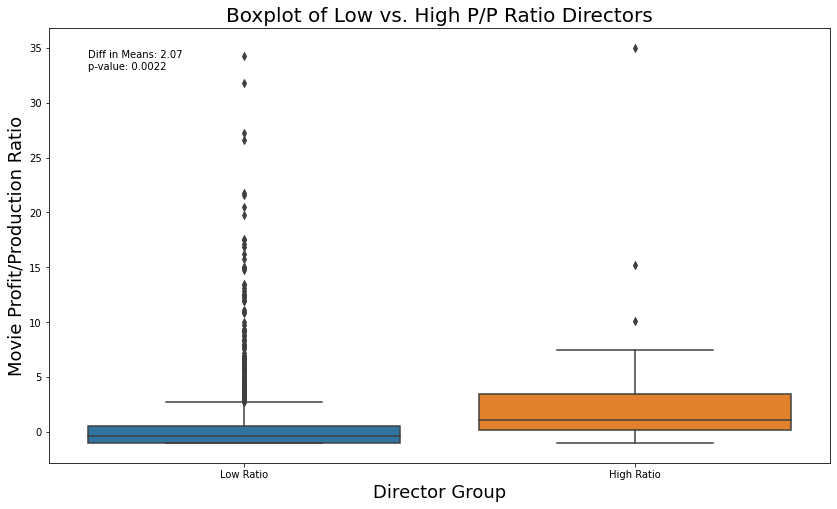

In [41]:
films_dir = films_dir.query('d_ppratio < 50')
plt.figure(figsize=(14, 8))
boxplot = sns.boxplot(x='hi_ppratio_dir', y='d_ppratio', data=films_dir)
boxplot.set_xticklabels(['Low Ratio', 'High Ratio'])
#plt.hlines(y=films_dir.d_ppratio.median(), xmin=0, xmax=2, 
#           colors='blue', linestyles='dashed', lw=1, label='median d_ppratio')
#plt.legend()
plt.text(0.05, 0.95, f'Diff in Means: {means_diff:.2f}\np-value: {p:.2g}', 
         ha='left', va='top', transform=plt.gca().transAxes)
plt.title('Boxplot of Low vs. High P/P Ratio Directors', fontsize=20)
plt.xlabel('Director Group', fontsize=18)
plt.ylabel('Movie Profit/Production Ratio', fontsize=18)
#plt.xticks(rotation=90)
plt.show()

In [42]:
films_dir = films_dir[films_dir['hi_ppratio_dir'] == True]

In [43]:
# Assuming 'data' is a pandas DataFrame with your categories as 'category'
# and the dependent variable as 'y'
H, p_value = stats.kruskal(*[group['d_ppratio'].values for name, group in films_dir.groupby('director')])

print('H-statistic:', H)
print('P-value:', p_value)

if p_value < 0.1:
    print("There is a significant difference between the categories at alpha=0.1.")
else:
    print("There is no significant difference between the categories at alpha=0.1.")

H-statistic: 10.912404092071625
P-value: 0.6929032780223414
There is no significant difference between the categories at alpha=0.1.


In [44]:
alpha = 0.1
mc = MultiComparison(films_dpp['d_ppratio'], films_dir['director'])

result = mc.tukeyhsd(alpha=alpha)
#result.summary()
tukey_summary_df = pd.DataFrame(data=result._results_table.data[1:], columns=result._results_table.data[0])

# Filter the DataFrame to only show rows where 'reject' is True
significant_results = tukey_summary_df[tukey_summary_df['reject'] == True]

print(significant_results)

NameError: name 'films_dpp' is not defined

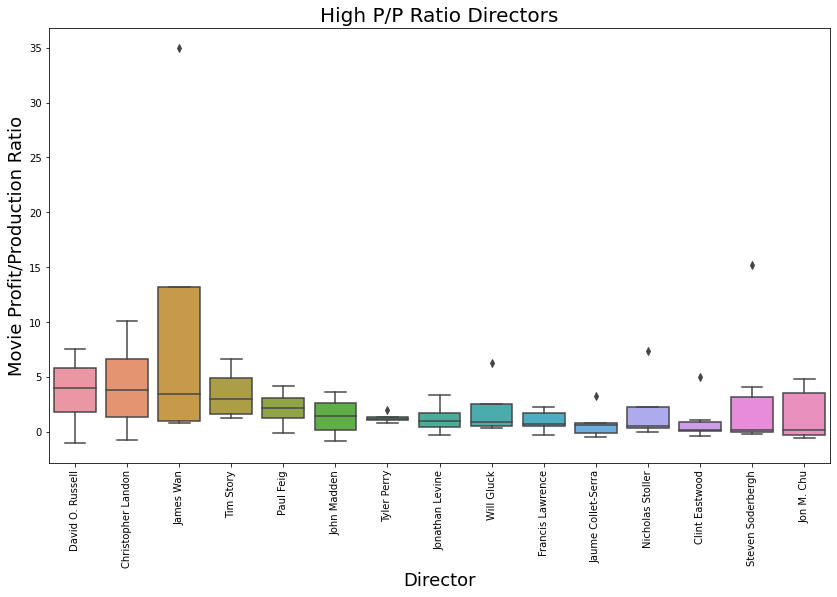

In [45]:
medians = films_dir.groupby('director')['d_ppratio'].median().sort_values(ascending=False)

# Reorder the original DataFrame based on the sorted medians
films_dir_sorted = films_dir.set_index('director').loc[medians.index].reset_index()

# Plot the boxplot using the reordered DataFrame
plt.figure(figsize=(14, 8))
sns.boxplot(x='director', y='d_ppratio', data=films_dir_sorted)

# Add a horizontal line for the overall median
#plt.hlines(y=films_dir.d_ppratio.median(), xmin=0, xmax=14, 
#           colors='blue', linestyles='dashed', lw=1, label='median d_ppratio')

# Add legend, rotate x-ticks and show the plot
plt.title('High P/P Ratio Directors', fontsize=20)
plt.xlabel('Director', fontsize=18)
plt.ylabel('Movie Profit/Production Ratio', fontsize=18)
#plt.legend()
plt.xticks(rotation=90)
plt.show()

---

---

## Analyzing d_pp_ratio by writer

In [46]:
films_writer = films[films['writer'].notna()]
df_exploded = films_writer.assign(writer=films_writer['writer'].str.split(',')).explode('writer')

# Step 2: Strip whitespace from the writer names
df_exploded['writer'] = df_exploded['writer'].str.strip()

# Step 3: Group by the writer names and calculate the mean of 'y'
writers = df_exploded.groupby('writer').agg(
    mean_ppratio=('d_ppratio', 'mean'),
    count=('d_ppratio', 'size')
).reset_index()

# The result is a DataFrame with the mean 'y' for each writer
writers = writers[writers['count'] > 3]
writers = writers.sort_values(by='mean_ppratio', ascending=False).head(15)
writers

,writer,mean_ppratio,count
2407,Oren Peli,11.325734,7
601,Christopher Landon,10.615487,6
1293,James DeMonaco,9.672991,4
673,Damien Chazelle,6.433448,4
936,Eli Roth,4.589548,4
2830,Scott Derrickson,4.308063,4
2204,Michael H. Weber,3.481493,4
2842,Scott Neustadter,3.481493,4
1784,Ken Daurio,2.728770,5
619,Cinco Paul,2.728770,5


In [47]:
writer_names = writers.writer.tolist()
writer_names

['Oren Peli',
 'Christopher Landon',
 'James DeMonaco',
 'Damien Chazelle',
 'Eli Roth',
 'Scott Derrickson',
 'Michael H. Weber',
 'Scott Neustadter',
 'Ken Daurio',
 'Cinco Paul',
 'Stephen King',
 'Jonah Hill',
 'Suzanne Collins',
 'Stephen Susco',
 'Ryan Engle']

In [49]:
def is_hi_ppratio_writer(row, writers_list):
    # Check if the row is a string instance to avoid AttributeError
    if isinstance(row, str):
        # Split the 'writer' column by commas and strip whitespace
        writers_in_row = [name.strip() for name in row.split(',')]
        # Check if any writer in the row is in the provided list
        return any(writer in writers_list for writer in writers_in_row)
    else:
        # If the row is not a string, return False or handle as needed
        return False

# Apply the function to each row in the 'writer' column
films_writers = films
films_writers['hi_ppratio_writer'] = films_writers['writer'].apply(is_hi_ppratio_writer, writers_list=writer_names)

In [53]:
hi_ppratio_writer = films_writers[films_writers['hi_ppratio_writer'] == True]['d_ppratio']
lo_ppratio_writer = films_writers[films_writers['hi_ppratio_writer'] == False]['d_ppratio']
stat, p = stats.ttest_ind(lo_ppratio_writer, hi_ppratio_writer)

In [54]:
desc_hi = sm.stats.DescrStatsW(hi_ppratio_writer)
desc_lo = sm.stats.DescrStatsW(lo_ppratio_writer)
compare = sm.stats.CompareMeans(desc_hi, desc_lo)
# Confidence interval for the mean difference
# Default is 95% CI, adjust with `alpha` parameter for other levels
conf_int = compare.tconfint_diff(usevar='unequal')
means_diff = hi_ppratio_writer.mean() - lo_ppratio_writer.mean()
print(f'mean difference: {hi_ppratio_writer.mean() - lo_ppratio_writer.mean()}')
print(f"Confidence Interval: {conf_int}")

mean difference: 4.38197743513224
Confidence Interval: (2.7149625989337953, 6.048992271330684)


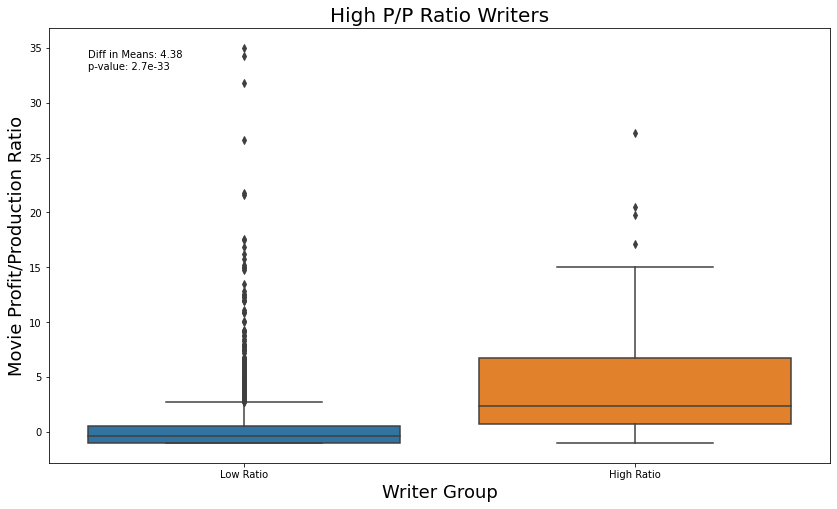

In [59]:
films_writers = films_writers.query('d_ppratio < 50')
plt.figure(figsize=(14, 8))
boxplot = sns.boxplot(x='hi_ppratio_writer', y='d_ppratio', data=films_writers)
boxplot.set_xticklabels(['Low Ratio', 'High Ratio'])
#plt.hlines(y=films.d_ppratio.median(), xmin=0, xmax=1, 
#           colors='blue', linestyles='dashed', lw=1, label='median d_ppratio')
plt.text(0.05, 0.95, f'Diff in Means: {means_diff:.2f}\np-value: {p:.2g}', 
         ha='left', va='top', transform=plt.gca().transAxes)
plt.title('High P/P Ratio Writers', fontsize=20)
plt.xlabel('Writer Group', fontsize=18)
plt.ylabel('Movie Profit/Production Ratio', fontsize=18)

#plt.legend()
#plt.xticks(rotation=90)
plt.show()

In [60]:
films_writers = films_writers[films_writers['hi_ppratio_writer'] == True]

In [61]:
top_writers = pd.DataFrame(columns=['writer', 'd_ppratio'])
for index, row in films_writers.iterrows():
    # Split the 'x' column by any separators if necessary and check for names
    for name in writer_names:
        if name in row['writer']:
            # If a name is found, append it and the 'y' value to the new DataFrame
            top_writers = top_writers.append({'writer': name, 'd_ppratio': row['d_ppratio']}, ignore_index=True)
top_writers

,writer,d_ppratio
0,Stephen King,1.605938
1,Damien Chazelle,13.416600
2,Scott Derrickson,0.409951
3,Jonah Hill,2.296373
4,Stephen Susco,-0.986097
...,...,...
62,Jonah Hill,0.587468
63,Stephen Susco,7.866745
64,James DeMonaco,4.345288
65,Ryan Engle,6.806765


<Figure size 1008x576 with 0 Axes>

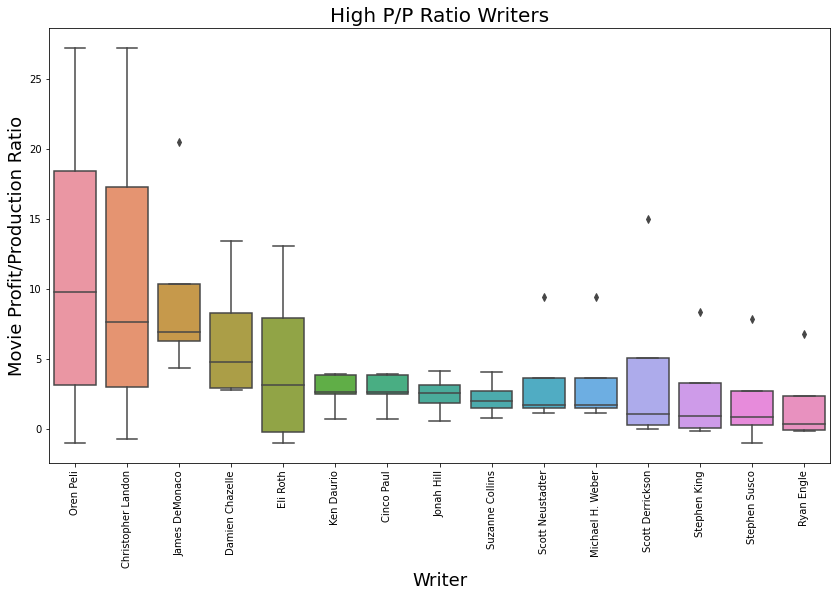

In [69]:
plt.figure(figsize=(14, 8))
medians = top_writers.groupby('writer')['d_ppratio'].median().sort_values(ascending=False)
top_writers_sorted = top_writers.set_index('writer').loc[medians.index].reset_index()
plt.figure(figsize=(14, 8))
sns.boxplot(x='writer', y='d_ppratio', data=top_writers_sorted)

# Add a horizontal line for the overall median
#plt.hlines(y=top_writers.d_ppratio.median(), xmin=0, xmax=14, 
#           colors='blue', linestyles='dashed', lw=1, label='median d_ppratio')

# Add legend, rotate x-ticks and show the plot
#plt.legend()
plt.title('High P/P Ratio Writers', fontsize=20)
plt.xlabel('Writer', fontsize=18)
plt.ylabel('Movie Profit/Production Ratio', fontsize=18)
plt.xticks(rotation=90)
plt.show();

---

---

## Analyzing d_pp_ratio by actor

In [66]:
films_actors = films[films['actors'].notna()]
df_exploded = films_actors.assign(actors=films_actors['actors'].str.split(',')).explode('actors')

# Step 2: Strip whitespace from the writer names
df_exploded['actors'] = df_exploded['actors'].str.strip(" '\"[]")

# Step 3: Group by the writer names and calculate the mean of 'y'
actors = df_exploded.groupby('actors').agg(
    mean_ppratio=('d_ppratio', 'mean'),
    count=('d_ppratio', 'size')
).reset_index()

# The result is a DataFrame with the mean 'y' for each writer
actors = actors[actors['count'] > 3]
actors = actors.sort_values(by='mean_ppratio', ascending=False).head(15)
actors

,actors,mean_ppratio,count
3271,Octavia Spencer,6.426386,5
678,Catherine Keener,6.018481,6
3673,Rose Byrne,5.387734,9
1325,Ethan Hawke,5.147261,8
2729,Mahershala Ali,4.797368,4
2971,Michael B. Jordan,4.468320,6
3344,Patrick Wilson,4.411012,9
3159,Naomie Harris,4.292865,4
1424,Gabrielle Union,4.063752,4
3291,Olivia Munn,3.652625,4


In [67]:
actor_names = actors.actors.tolist()
actor_names

['Octavia Spencer',
 'Catherine Keener',
 'Rose Byrne',
 'Ethan Hawke',
 'Mahershala Ali',
 'Michael B. Jordan',
 'Patrick Wilson',
 'Naomie Harris',
 'Gabrielle Union',
 'Olivia Munn',
 'Lena Headey',
 'Frank Grillo',
 'Mary Elizabeth Winstead',
 'John Corbett',
 'Michael Ealy']

In [70]:
def is_hi_ppratio_actor(row, actors_list):
    # Check if the row is a string instance to avoid AttributeError
    if isinstance(row, str):
        # Split the 'actors' column by commas and strip whitespace and quotes
        actors_in_row = [name.strip(" '\"[]") for name in row.split(',')]
        # Check if any actor in the row is in the provided list
        return any(actor in actors_list for actor in actors_in_row)
    else:
        # If the row is not a string, return False or handle as needed
        return False

# Apply the function to each row in the 'actors' column
films_actors = films
films_actors['hi_ppratio_actor'] = films_actors['actors'].apply(is_hi_ppratio_actor, actors_list=actor_names)

In [75]:
hi_ppratio_actor = films_actors[films_actors['hi_ppratio_actor'] == True]['d_ppratio']
lo_ppratio_actor = films_actors[films_actors['hi_ppratio_actor'] == False]['d_ppratio']
stat, p = stats.ttest_ind(lo_ppratio_actor, hi_ppratio_actor)

In [79]:
desc_hi = sm.stats.DescrStatsW(hi_ppratio_actor)
desc_lo = sm.stats.DescrStatsW(lo_ppratio_actor)
compare = sm.stats.CompareMeans(desc_hi, desc_lo)
# Confidence interval for the mean difference
# Default is 95% CI, adjust with `alpha` parameter for other levels
conf_int = compare.tconfint_diff(usevar='unequal')
means_diff = hi_ppratio_actor.mean() - lo_ppratio_actor.mean()
print(f'mean difference: {hi_ppratio_actor.mean() - lo_ppratio_actor.mean()}')
print(f"Confidence Interval: {conf_int}")

mean difference: 3.2967456652288036
Confidence Interval: (1.6589377179524052, 4.934553612505203)


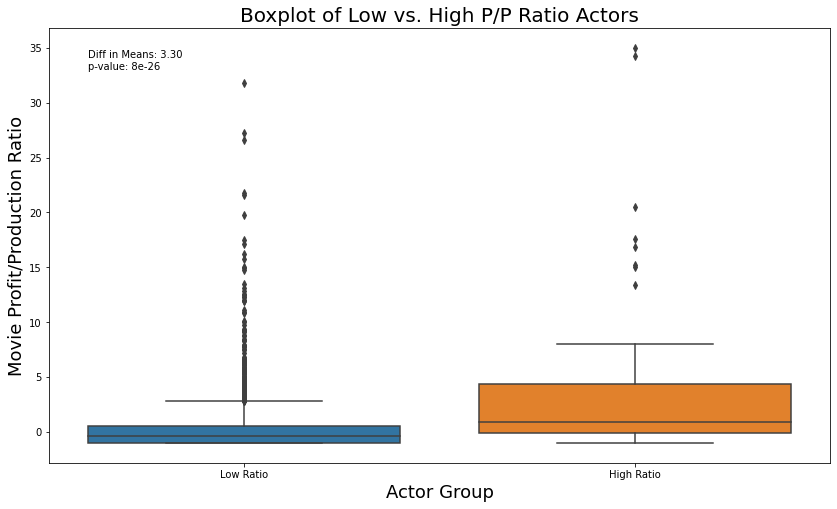

In [80]:
films_actors = films_actors.query('d_ppratio < 50')
plt.figure(figsize=(14, 8))
boxplot = sns.boxplot(x='hi_ppratio_actor', y='d_ppratio', data=films_actors)
boxplot.set_xticklabels(['Low Ratio', 'High Ratio'])
plt.text(0.05, 0.95, f'Diff in Means: {means_diff:.2f}\np-value: {p:.2g}', 
         ha='left', va='top', transform=plt.gca().transAxes)
plt.title('Boxplot of Low vs. High P/P Ratio Actors', fontsize=20)
plt.xlabel('Actor Group', fontsize=18)
plt.ylabel('Movie Profit/Production Ratio', fontsize=18)
#plt.xticks(rotation=90)
plt.show()

In [81]:
films_actors = films_actors[films_actors['hi_ppratio_actor'] == True]

In [82]:
top_actors = pd.DataFrame(columns=['actor', 'd_ppratio'])
for index, row in films_actors.iterrows():
    # Split the 'x' column by any separators if necessary and check for names
    for name in actor_names:
        if name in row['actors']:
            # If a name is found, append it and the 'y' value to the new DataFrame
            top_actors = top_actors.append({'actor': name, 'd_ppratio': row['d_ppratio']}, ignore_index=True)
top_actors

,actor,d_ppratio
0,Mahershala Ali,-0.495822
1,Catherine Keener,0.386433
2,Patrick Wilson,-1.000000
3,John Corbett,0.744467
4,Catherine Keener,0.344525
...,...,...
75,Ethan Hawke,-0.014784
76,Michael B. Jordan,1.314318
77,Mahershala Ali,2.699138
78,Gabrielle Union,6.806765


<Figure size 1008x576 with 0 Axes>

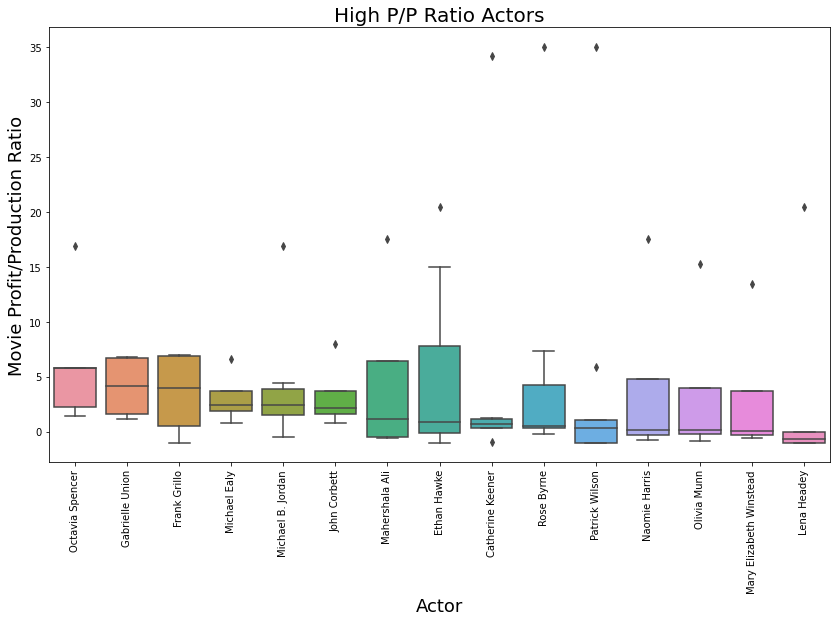

In [86]:
plt.figure(figsize=(14, 8))
medians = top_actors.groupby('actor')['d_ppratio'].median().sort_values(ascending=False)
top_actors_sorted = top_actors.set_index('actor').loc[medians.index].reset_index()
plt.figure(figsize=(14, 8))
sns.boxplot(x='actor', y='d_ppratio', data=top_actors_sorted)
plt.title('High P/P Ratio Actors', fontsize=20)
plt.xlabel('Actor', fontsize=18)
plt.ylabel('Movie Profit/Production Ratio', fontsize=18)
plt.xticks(rotation=90)
plt.show()

---

---